In [1]:
## Loading the necessary libraries:

library(reshape2)
library(ggplot2)
library(corrplot)
library(mvtnorm)
library(repr)

corrplot 0.84 loaded



In [2]:
## Reading the training and testing files in R:

train_data <- read.csv("Task1E_train.csv", header = TRUE)
test_data <- read.csv("Task1E_test.csv", header = TRUE)

In [3]:
## Split data to train and test datasets:

train.len <- nrow(train_data)
train.data <- train_data[ , -3] 
train.label <- train_data[ , 3] 

test.len <- nrow(test_data)
test.data <- test_data[ , -3]
test.label <- test_data[ , 3]

In [4]:
unique(train_data[["y"]])

[1] -1  1

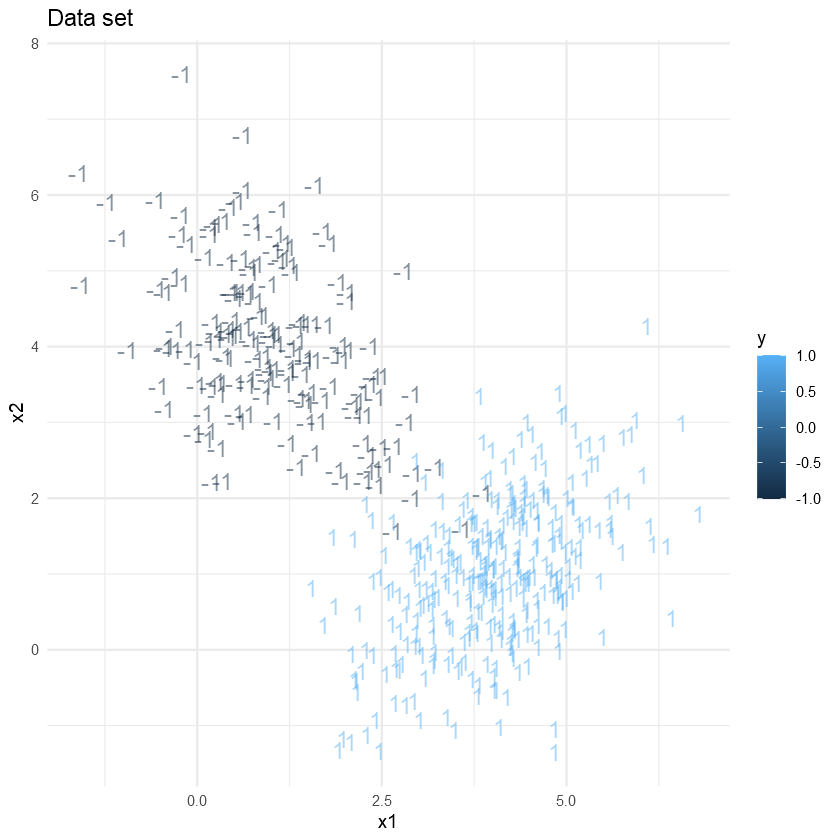

In [5]:
## Take a look at the data set:

ggplot(data=train_data, aes(x=x1, y=x2,  color=y, label=ifelse(y=='-1', '-1', '1'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') +  
    theme_minimal()

In [6]:
## Class labels:

c0 <- '1'; c1 <- '-1' 

# Bayesian Classifier:

In [7]:
## Defining Bayesian Classifier function which will take number of data as input and return the training and testing
## errors for LR:

Bayesian_Classifier <- function (n=3){

    ## Class probabilities:

    p0.hat <- sum(train.label[1:n]==c0)/n      ## Total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label[1:n]==c1)/n      ## Or 1 - p1.hat

    #p0.hat
    #p1.hat
    
    ## Class means:

    mu0.hat <- colMeans(na.omit(train.data[1:n,][train.label==c0,]))
    mu1.hat <- colMeans(na.omit(train.data[1:n,][train.label==c1,]))

    #mu0.hat
    #mu1.hat
    
    ## Class covariance matrices:

    sigma0.hat <- var(na.omit(train.data[1:n,][train.label==c0,]))
    sigma1.hat <- var(na.omit(train.data[1:n,][train.label==c1,]))

    #sigma0.hat
    #sigma1.hat
    
    ## Shared covariance matrix:
    
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    #sigma.hat
    
    
    ## Calculate posteriors:

    posterior0 <- p0.hat*dmvnorm(x=train.data[1:n,], mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data[1:n,], mean=mu1.hat, sigma=sigma.hat)

    #posterior0
    #posterior1
    
    train.predictions <- ifelse(posterior0 > posterior1, c0, c1)
    test.predictions <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    BC_train_errors <- sum(train.label[1:n]!=train.predictions)/n
    BC_test_errors <- sum(test.label!=test.predictions)/test.len
    
    return (c(BC_train_errors, BC_test_errors))
    }

In [8]:
## Training for 5 datapoints by calling Bayesian_Classifier():

errors<-Bayesian_Classifier(5)
errors_train<- unlist(errors[1])                                    ## Train errors
errors_train

errors_test<- unlist(errors[2])                                     ## Test errors
errors_test

[1] 0.8

[1] 0.684

# Logistic Regression:

In [9]:
## Auxiliary function that predicts class labels:

predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [10]:
## Defining Logistic Regression function which will take number of data as input and return the training and testing
## errors for LR:

LR_pred <- function(n=3){
    ## Initializations:
    tau.max <- 1000                                                    ## Maximum number of iterations
    eta <- 0.01                                                        ## Learning rate
    epsilon <- 0.01                                                    ## A threshold on the cost (to terminate the process)
    tau <- 1                                                           ## Iteration counter
    terminate <- FALSE
    
    X <- as.matrix(train.data)                                         ## Rename just for conveniance
    T <- ifelse(train.label==c0,0,1)                                   ## Rename just for conveniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1))                       ## Store the estimated coefficients
    W[1,] <- runif(ncol(W))                                            ## initial weight (can be initialized to 0 too)

    # Project data using the sigmoid function:
    
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)                               ## To trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    while(!terminate){
        
        ## Check termination criteria:
        
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
        ## Shuffle data:
        
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        ## For each datapoint:
        
        for (i in 1:n){
            
            ## Check termination criteria:
            
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            ## Update the weights:
            
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            ## record the cost:
            
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)

            ## update the counter:
            
            tau <- tau + 1

            ## decrease learning rate:
            
            eta = eta * 0.999
    }
}
    
    ## Remove the NaN tail of the vector (in case of early stopping):
    
    costs <- costs[1:tau, ] 

    ## The  final result is:
    
    w <- W[tau,]

    
    LR_train_errors <- sum(predict(w,train.data[1:n,],c0,c1)!=train.label[1:n])/n
    LR_test_errors <- sum(predict(w,test.data,c0,c1)!=test.label)/nrow(test.data)
    
    return(c(LR_train_errors,LR_test_errors))
}

In [11]:
## Training for 5 datapoints by calling LR_pred():

lr_weight1 <- (LR_pred(5))

err1 <- unlist(lr_weight1[1])                             ## Train errors
err2 <- unlist(lr_weight1[2])                             ## Test errors
err1
err2

[1] 0

[1] 0.012

## Sequential batches:

In [12]:
## Dataframes to hold batches, errors for BC and LR:

train_errors=data.frame('batches'=rep(1:100),'BC_train'=rep(1:100),'LR_train'=rep(1:100))
test_errors=data.frame('batches'=rep(1:100),'BC_test'=rep(1:100),'LR_test'=rep(1:100))

    

k=1

## For each batch:

for (batch in seq(5,nrow(train.data),5)){

    ## Training errors:
    
    errors_bc<-Bayesian_Classifier(batch)
    
    lr_weight <- LR_pred(batch)


    
    ## Updating the values in the dataframes:
    
    train_errors[k,'batches'] <- batch
    
    train_errors[k,'BC_train'] <- unlist(errors_bc[1])
    
    train_errors[k,'LR_train'] <- unlist(lr_weight[1])
    
    # sum(predict(lr_weight,train.data[1:batch,],c0,c1)!=train.label[1:batch])/batch
    
    #print(batch)
    
    ## Testing errors:
    
    test_errors[k,'batches'] <- batch
    
    test_errors[k,'BC_test'] <- unlist(errors_bc[2])
    
    #sum(test.label!=unlist(errors_bc[2]))/nrow(test.data)
    
    test_errors[k,'LR_test'] <- unlist(lr_weight[2])
    
    # sum(predict(lr_weight,test.data,c0,c1)!=test.label)/nrow(test.data)


    k=k+1
}


In [13]:
test_errors[test_errors$"batches" %in% c(250),]

,batches,BC_test,LR_test
,<dbl>,<dbl>,<dbl>
50,250,0.022,0.014


In [14]:
test_errors[test_errors$"batches" %in% c(5),]

,batches,BC_test,LR_test
,<dbl>,<dbl>,<dbl>
1,5,0.684,0.014


## Training errors:

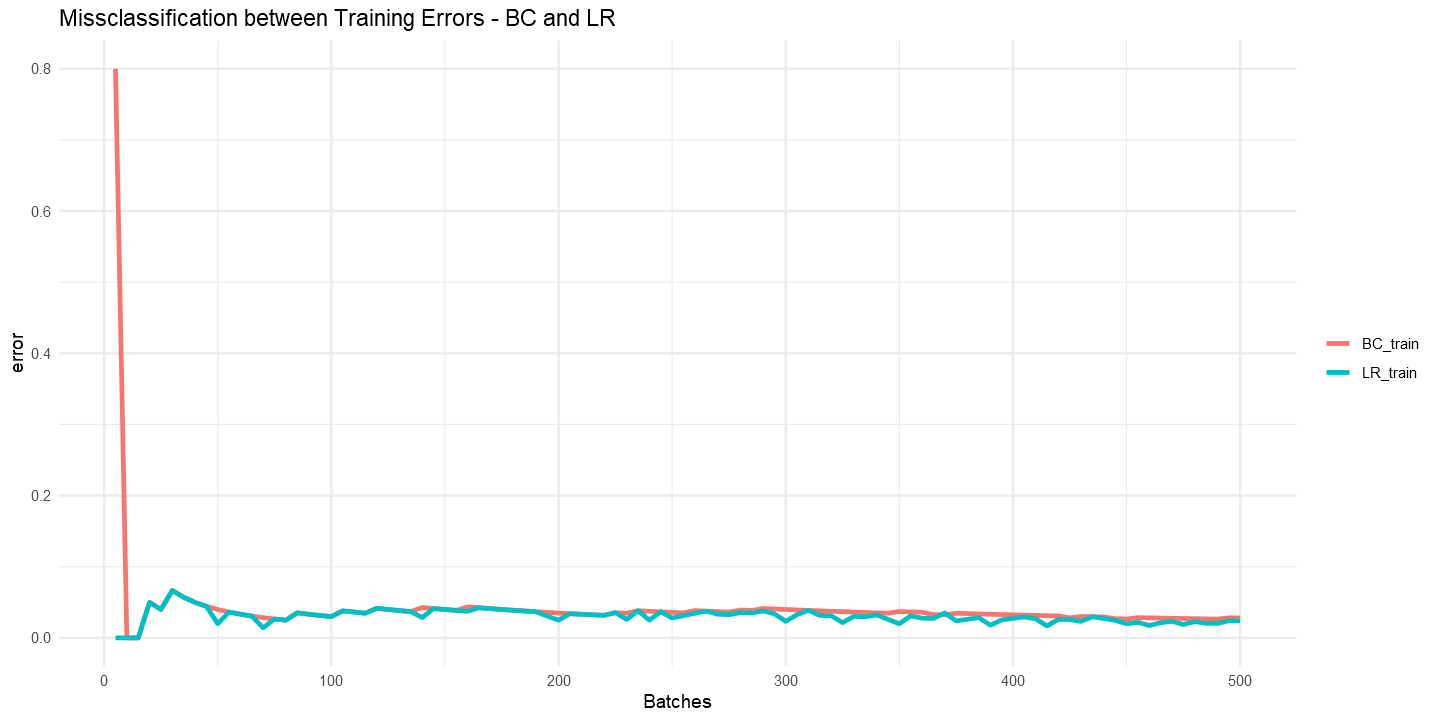

In [15]:
# plot misclassification percentage for train and test data sets
train_errors.m <- melt(train_errors, id='batches') # reshape for visualization
names(train_errors.m) <- c('Batches', 'type', 'error')

options(repr.plot.width=12, repr.plot.height=6)

ggplot(data=train_errors.m, aes(x=Batches, y=error, color=type)) + geom_line(size=1) +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Missclassification between Training Errors - BC and LR")

## Testing errors:

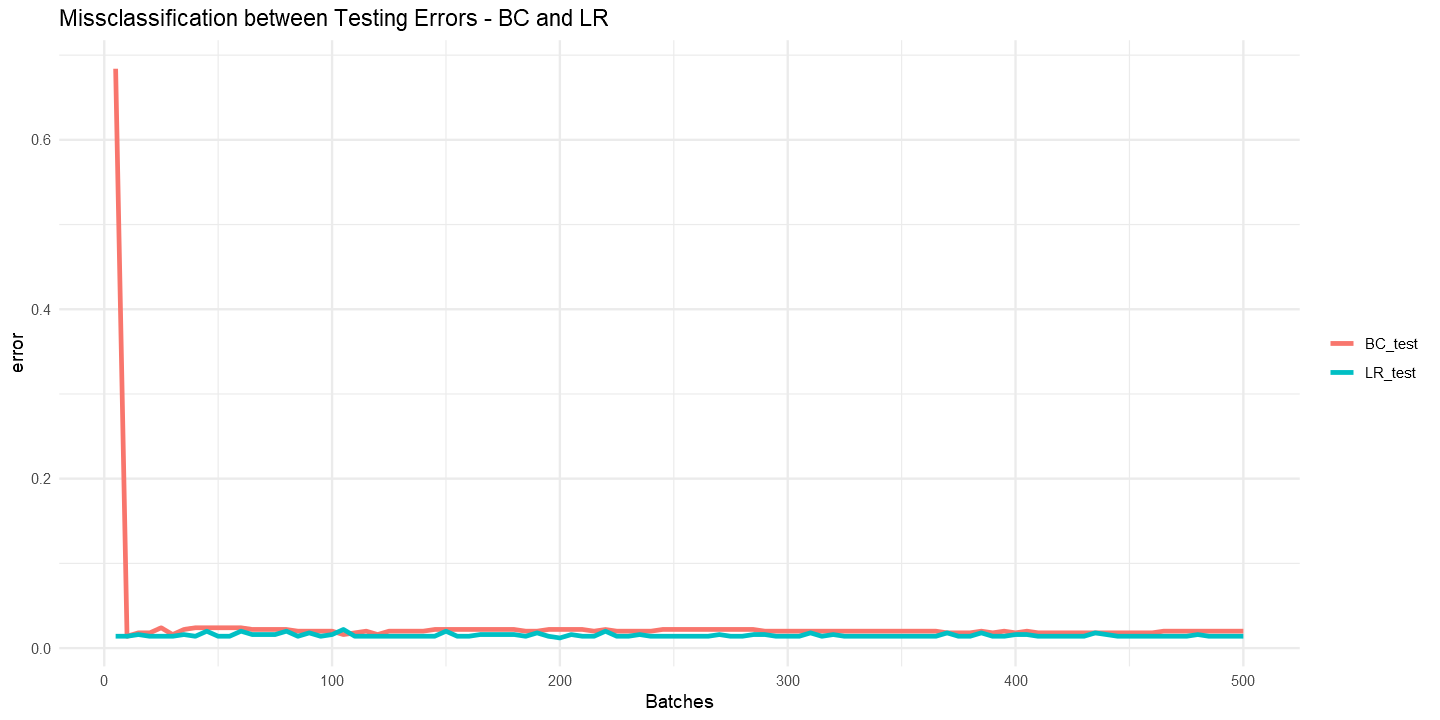

In [16]:
# Plot misclassification percentage for train and test data sets:

test_errors.m <- melt(test_errors, id='batches') # reshape for visualization
names(test_errors.m) <- c('Batches', 'type', 'error')

options(repr.plot.width=12, repr.plot.height=6)

ggplot(data=test_errors.m, aes(x=Batches, y=error, color=type)) + geom_line(size=1) +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Missclassification between Testing Errors - BC and LR")

## III:

1. What does happen for each classifier when the number of training data points is increased?

    - Training Error for **Bayesian Classifier** is highest for the first batch and it decreases significantly hereafter.
    - Training Error for **Logistic Regression** is 0 at the beginning and fluctuating for the starting iterations but are somewhat low for higher batches.
    - In general, it can be said that for the given dataset, as the training data increases, the misclassification rate decreases.


2. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

    - <b>Logistic Regression</b> is most appropriate for <b>smaller training dataset</b> as the error is low from the starting itself while the <b>Bayesian Classifier</b> works well when the <b>training set is big</b>.


3. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons:

    - As we can see LR error rates are always low as compared to Bayesian Classifier (smaller and bigger datasets) and therefore it can be said that Logistic Regression is appropriate for any dataset.
    - However, Bayesian Classifier requires more data so that it can learn better and reduce the error rate in misclassification.
    - A major point in using bayesian models is incorporating prior knowledge. 
    - With huge datasets, the prior (NB smoothing) will be pretty irrelevant, as there's plenty of direct evidence from data and hence sampling is done from the same population, model tends to perform better and as the sample size increases the sample mean tends to population mean.